In [1]:
# General imports
import numpy as np
import matplotlib.pyplot as plt

# Seg Map imports
from scipy.ndimage import label
from astropy.table import Table
from astropy.io import fits
from IPython.display import clear_output

In [2]:
# Read in Table and sort with highest Z first
hlss_tbl = Table.read("/Users/keith/astr/research_astr/FOV0/catalogs/MOT_SCA1_roll_0_dither_0x_0y_cut_zcut.txt",
                      format='ascii')
hlss_tbl.sort(['Z'], reverse=True)

# Store len and instantiate empty seg_map
total_obj = len(hlss_tbl)
seg_map = np.zeros((4088,4088))

In [3]:
# Define ellipse functions
A = lambda theta, a, b: ((np.sin(theta)**2)/(a**2)) + ((np.cos(theta)**2)/(b**2))
B = lambda theta, a, b: 2 * np.sin(theta) * np.cos(theta) * ((1/b**2) - (1/a**2))
C = lambda theta, a, b: ((np.sin(theta)**2)/(b**2)) + ((np.cos(theta)**2)/(a**2))

gen_ellipse = lambda x,y,x_0,y_0, ell: (A(*ell) * (x - x_0)**2) + (B(*ell) * (x - x_0) * (y - y_0)) + (C(*ell) * (y - y_0)**2)

Labelling  10763  of  10763


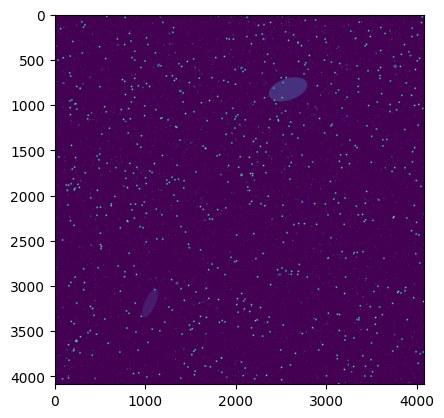

In [4]:
# Create meshgrid; meshgrid acts like seg_map pixel indicies
y = np.arange(4088)
x = np.arange(4088)
x_grid, y_grid = np.meshgrid(x,y)
del x
del y

# Loop through all objects, tracking how many are done
ii = 1
for object in hlss_tbl:

    clear_output(wait=True)
    print("Labelling ", ii, " of ", total_obj)

    # Take object info
    num = object["NUMBER"]
    a = object["A_IMAGE"]
    b = object["B_IMAGE"]
    theta = object["THETA_IMAGE"]
    x_0 = object["X_IMAGE"]
    y_0 = object["Y_IMAGE"]

    # Find all values within object's ellipse
    ellipse = lambda x,y: gen_ellipse(x, y, x_0, y_0, (theta, a, b))
    condition = ellipse(x_grid, y_grid) <= 1

    # Set all values equal to object id
    seg_map[np.where(condition)] = num
    ii += 1

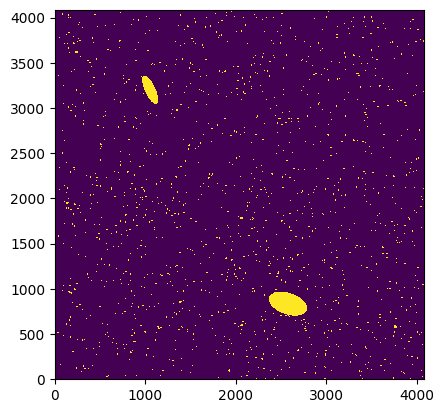

In [15]:
# Show seg map
plt.imshow(seg_map, origin='lower', vmin=0, vmax=1, interpolation='nearest')

In [7]:
# Save seg_map
ready_direct = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/ready_direct_GRS_FOV0_roll0_dx0_dy0_SCA1_direct_final.fits"
seg_from_MOT = "/Users/keith/astr/research_astr/summer-roman-project/4) FOV0_sims/fits/seg_from_MOT.fits"

# Take header info from prepared direct image
file = fits.open(ready_direct)
hdr = file[1].header
file.close()

fits.writeto(seg_from_MOT, data=np.rot90(seg_map, k=3), header=hdr)